In [1]:
from mpl_toolkits import mplot3d
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import interactive
import time
import board
import digitalio
from numpy import interp
from adafruit_servokit import ServoKit
kit = ServoKit(channels=16 , frequency=300)

def setupView(limit):
    ax = plt.axes(projection="3d")
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_zlim(-limit, limit)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_zlabel("Y")
    return ax

In [2]:
relay = digitalio.DigitalInOut(board.D17)
relay.direction = digitalio.Direction.OUTPUT
relay.value = False

## Inverse Kinematics of Leg

Inverse kinematics is the process of obtaining joint angles from known coordinates of the end effector. In this case the end effector is the foot of the leg and the joint angles are what we would write to the servos. 


## Coordinate Systems of Leg Joints
From the figure below, in my leg model performing measurements from the centers of the rotational axis, l1 = 50mm, l2 = 100mm, l3 = 100mm.
![image.png](attachment:27f0a3ea-d431-4f1b-ba66-350f930a588e.png )
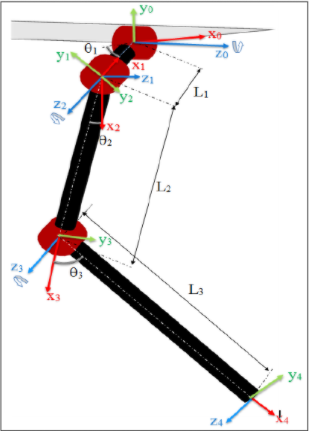

### Inverse Kinematic Function

The function to solve the leg inverse kinematics is based on the equations below. There are two theta3's in the equations below which account for right and left legs, we will use the equation for 2 and 4 and flip the leg along the x axis later on.

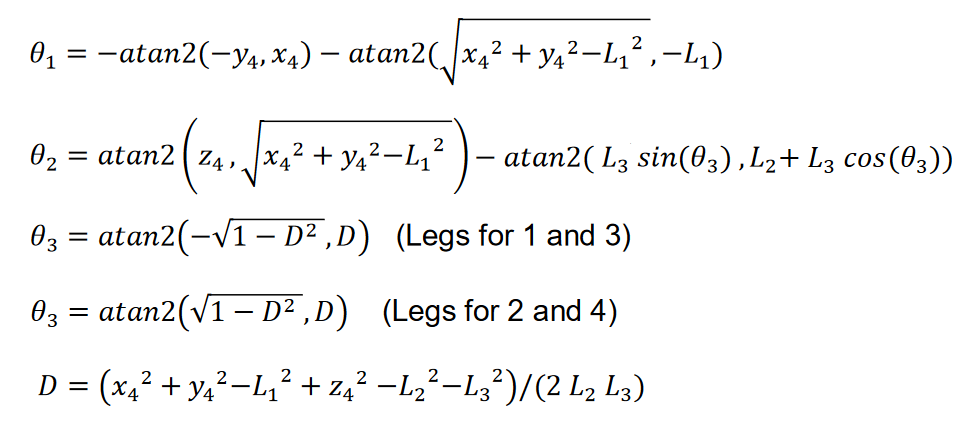

In [3]:
   #In mm
    l1 = 50
    l2 = 100
    l3 = 100

In [4]:
def solve_legIK_L(x,y,z):

    D = (x**2+y**2-l1**2+z**2-l2**2-l3**2)/(2*l2*l3)
    theta1 = -atan2(y,x)-atan2(sqrt(x**2+y**2-l1**2),-l1)
    theta3 = atan2(sqrt(1-D**2),D)
    theta2 = atan2(z, sqrt(x**2+y**2-l1**2))-atan2(l3*sin(theta3), l2+l3*cos(theta3))
    return (theta1, theta2, theta3)

In [5]:
def calcLegPoints(angles):
    
    (theta1,theta2,theta3)=angles
    theta23=theta2+theta3

    T0=np.array([0,0,0,1])
    T1=T0+np.array([-l1*cos(theta1),l1*sin(theta1),0,0])
    T2=T1+np.array([-l2*sin(theta1)*cos(theta2),-l2*cos(theta1)*cos(theta2),l2*sin(theta2),0])
    T3=T2+np.array([-l3*sin(theta1)*cos(theta23),-l3*cos(theta1)*cos(theta23),l3*sin(theta23),0])
        
    return np.array([T0,T1,T2,T3])

In [6]:
def drawLegPoints(p):

    plt.plot([p[0][0],p[1][0],p[2][0],p[3][0]], 
             [p[0][2],p[1][2],p[2][2],p[3][2]],
             [p[0][1],p[1][1],p[2][1],p[3][1]], 'k-', lw=3)
    plt.plot([p[0][0]],[p[0][2]],[p[0][1]],'bo',lw=2)
    plt.plot([p[3][0]],[p[3][2]],[p[3][1]],'ro',lw=2)
    print([p[3][0]],[p[3][1]],[p[3][2]])

[-50.0] [-141.4] [60.0]


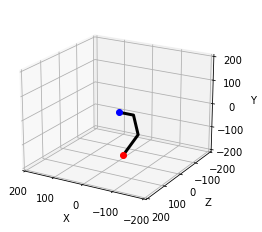

In [7]:
%matplotlib inline

setupView(200).view_init(elev=20., azim=120)
x= -50
y= -141.4
z= 60


drawLegPoints(calcLegPoints(solve_legIK_L(x,y,z)))


In [8]:
L = 234 # in mm
W = 77

In [9]:
def bodyIK(omega,phi,psi,xm,ym,zm):

    """
    Calculate the four Transformation-Matrices for our Legs
    Rx=X-Axis Rotation Matrix
    Ry=Y-Axis Rotation Matrix
    Rz=Z-Axis Rotation Matrix
    Rxyz=All Axis Rotation Matrix
    T=Translation Matrix
    Tm=Transformation Matrix
    Trb,Trf,Tlb,Tlf=final Matrix for RightBack,RightFront,LeftBack and LeftFront
    """
    
    Rx = np.array([
        [1, 0, 0, 0], 
        [0, np.cos(omega), -np.sin(omega), 0],
        [0,np.sin(omega),np.cos(omega),0],
        [0,0,0,1]])

    Ry = np.array([
        [np.cos(phi),0, np.sin(phi), 0], 
        [0, 1, 0, 0],
        [-np.sin(phi),0, np.cos(phi),0],
        [0,0,0,1]])

    Rz = np.array([
        [np.cos(psi),-np.sin(psi), 0,0], 
        [np.sin(psi),np.cos(psi),0,0],
        [0,0,1,0],
        [0,0,0,1]])

    Rxyz=Rx@Ry@Rz

    T = np.array([[0,0,0,xm],[0,0,0,ym],[0,0,0,zm],[0,0,0,0]])
    Tm = T+Rxyz
    
    Trb = Tm @ np.array([
        [np.cos(pi/2),0,np.sin(pi/2),-L/2],
        [0,1,0,0],
        [-np.sin(pi/2),0,np.cos(pi/2),-W/2],
        [0,0,0,1]])

    Trf = Tm @ np.array([
        [np.cos(pi/2),0,np.sin(pi/2),L/2],
        [0,1,0,0],
        [-np.sin(pi/2),0,np.cos(pi/2),-W/2],
        [0,0,0,1]])

    Tlf = Tm @ np.array([
        [np.cos(pi/2),0,np.sin(pi/2),L/2],
        [0,1,0,0],
        [-np.sin(pi/2),0,np.cos(pi/2),W/2],
        [0,0,0,1]])

    Tlb = Tm @ np.array([
        [np.cos(pi/2),0,np.sin(pi/2),-L/2],
        [0,1,0,0],
        [-np.sin(pi/2),0,np.cos(pi/2),W/2],
        [0,0,0,1]])
    
    return (Tlf,Trf,Tlb,Trb,Tm)

[117.0, 117.0, -117.0, -117.0, 117.0] [38.5, -38.5, -38.5, 38.5, 38.5] [0.0, 0.0, 0.0, 0.0, 0.0]


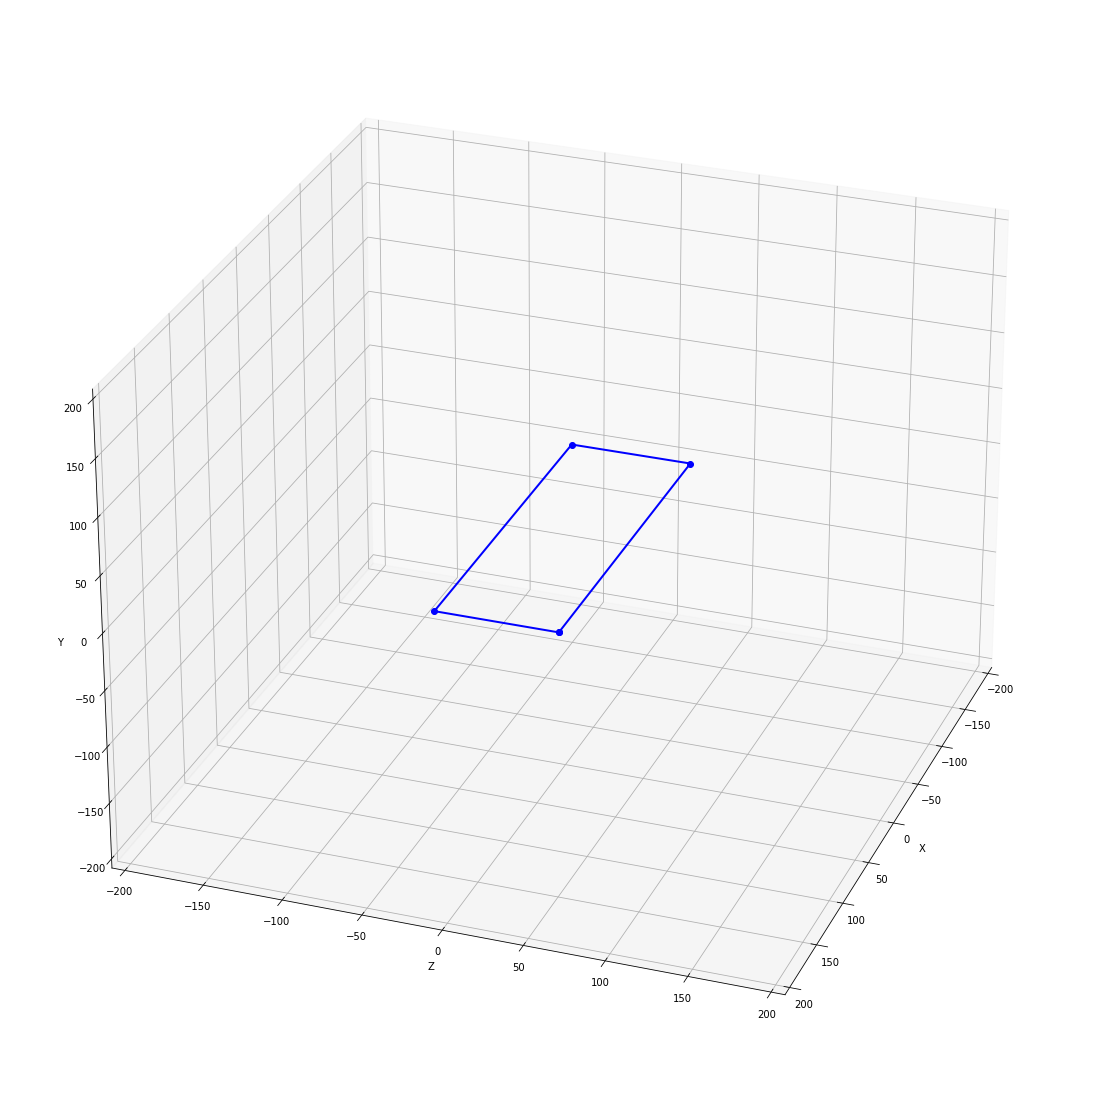

In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
omega = 0 # Body xrot
phi = 0#math.pi/4# Body YRot
psi = 0#math.pi/6 # Body ZRot

xm = 0
ym = 0
zm = 0

(Tlf,Trf,Tlb,Trb,Tm)=bodyIK(omega,phi,psi,xm,ym,zm)

FP=[0,0,0,1]

CP=[x@FP for x in [Tlf,Trf,Tlb,Trb]]

setupView(200).view_init(elev=27., azim=20)
plt.plot([CP[0][0],CP[1][0],CP[3][0], CP[2][0],CP[0][0]],
         [CP[0][2],CP[1][2],CP[3][2], CP[2][2],CP[0][2]],
         [CP[0][1],CP[1][1],CP[3][1], CP[2][1],CP[0][1]], 'bo-', lw=2)
print([CP[0][0],CP[1][0],CP[3][0], CP[2][0],CP[0][0]],
       [CP[0][2],CP[1][2],CP[3][2], CP[2][2],CP[0][2]],
      [CP[0][1],CP[1][1],CP[3][1], CP[2][1],CP[0][1]])


In [11]:

Lp=np.array([[117,-sqrt(200)*10,88.5,1],[117,-sqrt(200)*10,-88.5,1],[-117,-sqrt(200)*10,88.5,1],[-117,-sqrt(200)*10,-88.5,1]])

def drawRobot(Lp,bodyIk):

    (Tlf,Trf,Tlb,Trb,Tm)=bodyIk

    FP=[0,0,0,1]
    CP=[x@FP for x in [Tlf,Trf,Tlb,Trb]]

    [plt.plot([x[0]],[x[2]],[x[1]],'yo-') for x in Lp]

    plt.plot([CP[0][0],CP[1][0],CP[3][0],CP[2][0],CP[0][0]],
             [CP[0][2],CP[1][2],CP[3][2],CP[2][2],CP[0][2]],
             [CP[0][1],CP[1][1],CP[3][1],CP[2][1],CP[0][1]], 'bo-', lw=2)

    # Invert local X
    Ix=np.array([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

    #Q=np.linalg.inv(Tlf)@(Lp[0])
    Q=np.linalg.inv(Tlf)@Lp[0]
    p=[Tlf@x for x in calcLegPoints(solve_legIK_L(Q[0],Q[1],Q[2]))]
    #FL
    front_left = solve_legIK_L(Q[0],Q[1],Q[2])
    fl = [-front_left[0]*180/pi, front_left[1]*180/pi + 45,  front_left[2]*180/pi - 90]
    print(fl)
    drawLegPoints(p)

    Q=np.linalg.inv(Tlb)@Lp[2]
    p=[Tlb@x for x in calcLegPoints(solve_legIK_L(Q[0],Q[1],Q[2]))]
    #BL
    back_left = solve_legIK_L(Q[0],Q[1],Q[2])
    bl = [-back_left[0]*180/pi, back_left[1]*180/pi + 45, back_left[2]*180/pi - 90]
    print(bl)
    drawLegPoints(p)

    #TP=np.array([40,-150,0,1])

    Q=Ix@np.linalg.inv(Trf)@Lp[1]
    p=[Trf@Ix@x for x in calcLegPoints(solve_legIK_L(Q[0],Q[1],Q[2]))]
    #FR
    front_right = solve_legIK_L(Q[0],Q[1],Q[2])
    fr = [-front_right[0]*180/pi, front_right[1]*180/pi + 45, front_right[2]*180/pi - 90]
    print(fr)
    drawLegPoints(p)

    Q=Ix@np.linalg.inv(Trb)@Lp[3]
    p=[Trb@Ix@x for x in calcLegPoints(solve_legIK_L(Q[0],Q[1],Q[2]))]
    #BR
    back_right = solve_legIK_L(Q[0],Q[1],Q[2])
    br = [-back_right[0]*180/pi, back_right[1]*180/pi + 45, back_right[2]*180/pi - 90]
    print(br)
    drawLegPoints(p)
    
    return np.array ([fl, bl, br, fr])
 
print("OK")

OK


In [18]:
relay = digitalio.DigitalInOut(board.D17)
relay.direction = digitalio.Direction.OUTPUT

relay.value = False

In [13]:
#Servo Calibration
kit.servo[0].set_pulse_width_range(min_pulse=760, max_pulse = 2130)
kit.servo[1].set_pulse_width_range(min_pulse=810, max_pulse = 2180)
kit.servo[2].set_pulse_width_range(min_pulse=810, max_pulse = 2160)
kit.servo[3].set_pulse_width_range(min_pulse=870, max_pulse = 2225)
kit.servo[4].set_pulse_width_range(min_pulse=960, max_pulse = 2330)
kit.servo[5].set_pulse_width_range(min_pulse=890, max_pulse = 2160)
kit.servo[6].set_pulse_width_range(min_pulse=810, max_pulse = 2180)
kit.servo[7].set_pulse_width_range(min_pulse=780, max_pulse = 2140)
kit.servo[8].set_pulse_width_range(min_pulse=850, max_pulse = 2130)
kit.servo[9].set_pulse_width_range(min_pulse=800, max_pulse = 2170)
kit.servo[10].set_pulse_width_range(min_pulse=870, max_pulse = 2240)
kit.servo[11].set_pulse_width_range(min_pulse=860, max_pulse = 2140)

In [14]:
# Lie Down
angles = np.array([[0, -45, 60],   # FL
                   [0, -45, 60],   # BL
                   [0, -45, 60],   # BR
                   [0, -45, 60]])  # FR

In [15]:
# Normal Position
angles = np.array([[0, 0, 0],   # FL
                   [0, 0, 0],   # BL
                   [0, 0, 0],   # BR
                   [0, 0, 0]])  # FR
print(angles)

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


[-0.0, -0.397359644618156, -17.94597714878627]
[117.00000000000001] [-141.4213562373095] [88.5]
[-0.0, -18.569737046672493, 15.457694925964915]
[-117.0] [-141.4213562373095] [88.5]
[-0.0, -0.397359644618156, -17.94597714878627]
[117.00000000000001] [-141.4213562373095] [-88.5]
[1.2722218725854067e-14, -18.569737046672493, 15.457694925964915]
[-117.0] [-141.4213562373095] [-88.49999999999997]
[[-0.00000000e+00 -3.97359645e-01 -1.79459771e+01]
 [-0.00000000e+00 -1.85697370e+01  1.54576949e+01]
 [ 1.27222187e-14 -1.85697370e+01  1.54576949e+01]
 [-0.00000000e+00 -3.97359645e-01 -1.79459771e+01]]


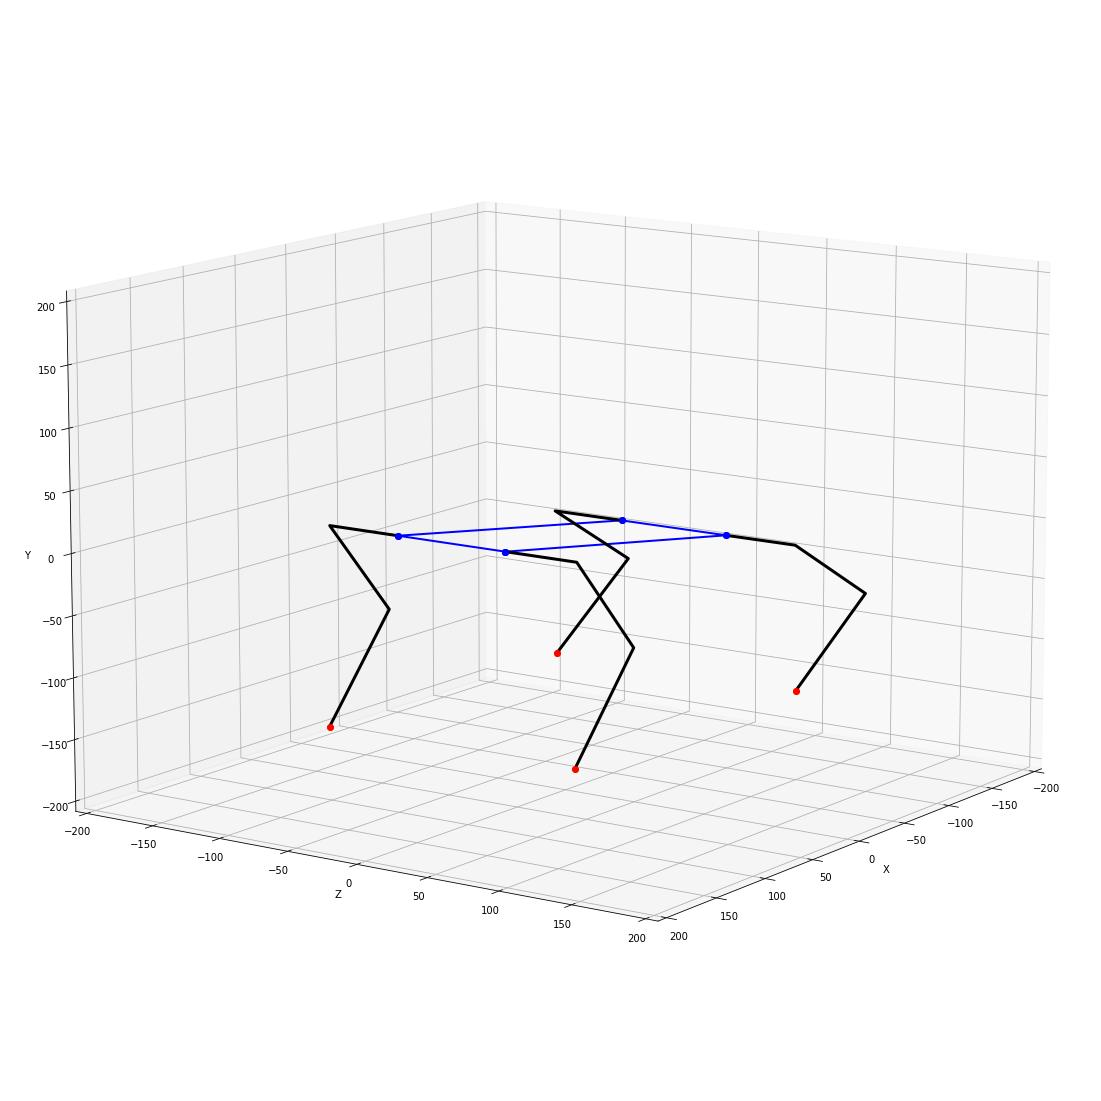

In [28]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
setupView(200).view_init(elev=12, azim=35)
# roll, yaw, pitch
roll = 0* pi/180
yaw = 0* pi/180
pitch = 10* pi/180
angles = drawRobot(Lp,bodyIK(roll,yaw,pitch,0,0,0))
print(angles)

In [29]:
# FL
if angles[0][0] >= -30 and angles[0][0] <= 30:
    kit.servo[0].angle = interp(angles[0][0], [-90, 90], [180, 0]) # Link 1

if angles[0][1] >= -90 and angles[0][1] <= 30:
    kit.servo[1].angle = interp(angles[0][1], [-90, 90], [180, 0]) # Link 2

if angles[0][2] >= -55 and angles[0][2] <= 60:
    kit.servo[2].angle = interp(angles[0][2], [-90, 90], [0, 180]) # Link 3

# BL
if angles[1][0] >= -30 and angles[1][0] <= 30:
    kit.servo[3].angle = interp(angles[1][0], [-90, 90], [0, 180]) # Link 1

if angles[1][1] >= -90 and angles[1][1] <= 30:
    kit.servo[4].angle = interp(angles[1][1], [-90, 90], [180, 0]) # Link 2

if angles[1][2] >= -55 and angles[1][2] <= 60:
    kit.servo[5].angle = interp(angles[1][2], [-90, 90], [0, 180]) # Link 3

# BR
if angles[2][0] >= -30 and angles[2][0] <= 30:
    kit.servo[6].angle = interp(angles[2][0], [-90, 90], [180, 0]) # Link 1

if angles[2][1] >= -90 and angles[2][1] <= 30:
    kit.servo[7].angle = interp(angles[2][1], [-90, 90], [0, 180]) # Link 2

if angles[2][2] >= -55 and angles[2][2] <= 60:
    kit.servo[8].angle = interp(angles[2][2], [-90, 90], [180, 0]) # Link 3

# FR
if angles[3][0] >= -30 and angles[3][0] <= 30:
    kit.servo[9].angle = interp(angles[3][0], [-90, 90], [0, 180]) # Link 1

if angles[3][1] >= -90 and angles[3][1] <= 30:
    kit.servo[10].angle = interp(angles[3][1], [-90, 90], [0, 180]) # Link 2

if angles[3][2] >= -55 and angles[3][2] <= 60:
    kit.servo[11].angle = interp(angles[3][2], [-90, 90], [180, 0]) # Link 3